## Ordinary Least Square Model


In [1]:

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as ss
import numpy as np
import scipy.stats as ss
import pandas as pd
import statsmodels.api as sm

from sklearn.ensemble import IsolationForest
from scipy.optimize import minimize
from pandas_datareader import data as pdr
from statsmodels.graphics.tsaplots import plot_acf
from pandas_datareader import DataReader

from pandas_datareader import DataReader
from datetime import datetime

from formulas import *
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

import yfinance as yf



### Defining Y variable as Tesla and adding  features 

In [2]:

TSLA = DataReader('TSLA',  'yahoo', datetime(2021,1,1), datetime(2021,8,30))
Y = np.diff(np.log(TSLA['Adj Close'].values))
T = Y.shape[0];



F = DataReader('SPY',  'yahoo', datetime(2021,1,1), datetime(2021,8,30))
F1 = np.diff(np.log(F['Adj Close'].values))
QQQ = DataReader('QQQ',  'yahoo', datetime(2021,1,1), datetime(2021,8,30))
F2 = np.diff(np.log(QQQ['Adj Close'].values))



### Performing OLS Regression Analysis


In [3]:

'Add Constant to X'
X = np.column_stack([np.ones(T),np.linspace(1,T,T), F1, F2])
N = X.shape[1]

'OLS REGRESSION STARTS'
'Linear Regression of Y: T x 1 on'
'Regressors X: T x N'
invXX = np.linalg.inv(X.transpose()@X)
'OLS estimates for coefficients: X x 1'
beta_hat = invXX@X.transpose()@Y
'Predictive value of Y using OLS'
y_hat = X@beta_hat
'Residuals from OLS'
residuals = Y - y_hat
'Variance of residuals'
sigma2 = (1/T)*residuals.transpose()@residuals
'standard deviation of Y or residuals'
sigma = np.sqrt(sigma2)







"'variance-covariance matrix of beta_hat'"

varcov_beta_hat = (sigma2)*invXX
std_beta_hat = np.sqrt(T*np.diag(varcov_beta_hat))

'Calculate R-square'
R_square = 1- (residuals.transpose()@residuals)/(T*np.var(Y))
adj_R_square = 1-(1-R_square)*(T-1)/(T-N)

'Test Each Coefficient: beta_i'
'Null Hypothesis: beta_i = 0'
t_stat = (beta_hat.transpose()-0)/std_beta_hat
p_val_t = 1-ss.norm.cdf(t_stat)

'Test of Joint Significance of Model'
F_stat = (beta_hat.transpose()@np.linalg.inv(varcov_beta_hat)@beta_hat/N)/\
         (residuals.transpose()@residuals/(T-N))

p_val_F = 1-ss.f.cdf(F_stat,N-1,T-N)


REPORT = np.column_stack([beta_hat, t_stat,p_val_t])

print('------------------------\n')
print(' REGRESSION STATISTICS  \n')
print('------------------------\n')
print(pd.DataFrame(REPORT,columns=['Beta','t statistics','p value']))
print('------------------------\n')
print('------------------------\n')
print('\n Joint significance of all coefficients\n')
print(pd.DataFrame(np.round([F_stat,p_val_F],6),columns=['Joint Signifinance'],index=['F stat','p value']))
print('------------------------\n')
print('\n R squared coefficients\n')
print(pd.DataFrame(np.round([R_square,adj_R_square,sigma,T],6),columns=['R Coefficents'],index=['R-Square','Adjusted R Square','Standard Error','Observations']))
print('------------------------\n')





------------------------

 REGRESSION STATISTICS  

------------------------

       Beta  t statistics   p value
0 -0.001708     -0.034336  0.513695
1 -0.000001     -0.002120  0.500846
2 -1.352692     -0.221894  0.587802
3  2.791041      0.677657  0.248995
------------------------

------------------------


 Joint significance of all coefficients

         Joint Signifinance
F stat         64438.961156
p value            0.000000
------------------------


 R squared coefficients

                   R Coefficents
R-Square                0.490376
Adjusted R Square       0.480880
Standard Error          0.024516
Observations          165.000000
------------------------



### Observations:
#### Coefficents and p-values for all the features is more than 5% which tells us that the market returns are not significantly influenced by dynamics of Tesla (Intercept is not significant)
#### Joint significance performed well as p-value is less than 5%
#### R squared is low, which shows the market aggregate can only determine 49% of the Data Dyamics

### Fama French Factor Model

In [4]:
import getFamaFrenchFactors as gff


#stock_data = yf.download(ticker, start, end, adjusted=True)
TSLA = DataReader('TSLA',  'yahoo', datetime(2018,1,1), datetime(2021,8,30))

ff3_monthly = gff.famaFrench3Factor(frequency='m')
ff3_monthly.rename(columns={"date_ff_factors": 'Date'}, inplace=True)
ff3_monthly.set_index('Date', inplace=True)

In [5]:
ff3_monthly.tail()

,Mkt-RF,SMB,HML,RF
Date,,,,
2021-06-30,0.0275,0.0180,-0.0776,0.0
2021-07-31,0.0127,-0.0396,-0.0175,0.0
2021-08-31,0.0290,-0.0048,-0.0013,0.0
2021-09-30,-0.0437,0.0080,0.0509,0.0
2021-10-31,0.0665,-0.0228,-0.0045,0.0


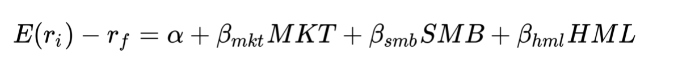

In [6]:

stock_returns = TSLA['Adj Close'].resample('M').last().pct_change().dropna()
stock_returns.name = "Month_Rtn"
ff_data = ff3_monthly.merge(stock_returns,on='Date')

In [7]:
X = ff_data[['Mkt-RF', 'SMB', 'HML']]
y = ff_data['Month_Rtn'] - ff_data['RF']
'Add Constant to X'
X.insert(loc=0,value=np.ones(len(X)),column='I')
N = X.shape[1]

'Linear Regression of Y: T x 1 on'
'Regressors X: T x N'
invXX = np.linalg.inv(X.transpose()@X)
'OLS estimates for coefficients: X x 1'
beta_hat = invXX@X.transpose()@y


#### Calculating the Intercept, coefficent of MKT_EXCESS, SML and HML

In [8]:
rf = ff_data['RF'].mean()
market_premium = ff3_monthly['Mkt-RF'].mean()
size_premium = ff3_monthly['SMB'].mean()
value_premium = ff3_monthly['HML'].mean()

intercept, b1, b2, b3 = beta_hat



In [9]:
print('------------------------\n')
print('Intercept ->',intercept)
print('MKT_EXCESS ->',b1)
print('SMB ->',b2)
print('HML ->',b3)

------------------------

Intercept -> 0.036793433008481584
MKT_EXCESS -> 2.3110519313202325
SMB -> -0.4187444814633089
HML -> -0.9269830945528543


#### Combining all the parameters into one functions to calculate the portfolio returns against the Fama French Model

In [10]:
expected_monthly_return = rf + b1 * market_premium + b2 * size_premium + b3 * value_premium 
expected_yearly_return = expected_monthly_return * 12
print("Expected yearly return: " + str(expected_yearly_return))

Expected yearly return: 0.15679859424062975


### Suggestion : Add momentum factor

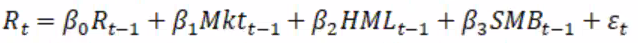

### ARIMA Model ( Autoregressive Integrated Moving Average Model)

In [11]:
tsla = yf.Ticker("TSLA")

# To get stock info
tsla.info

# get historical market data as df
hist = tsla.history(period="max")

# Save dataframe as CSV file
hist.to_csv('TSLA.CSV')

# Read data in to dataframes
tsla = pd.read_csv('TSLA.CSV')

# Change date column to datetime type
tsla['Date'] = pd.to_datetime(tsla['Date'])

tsla.dropna(inplace=True)

<AxesSubplot:>

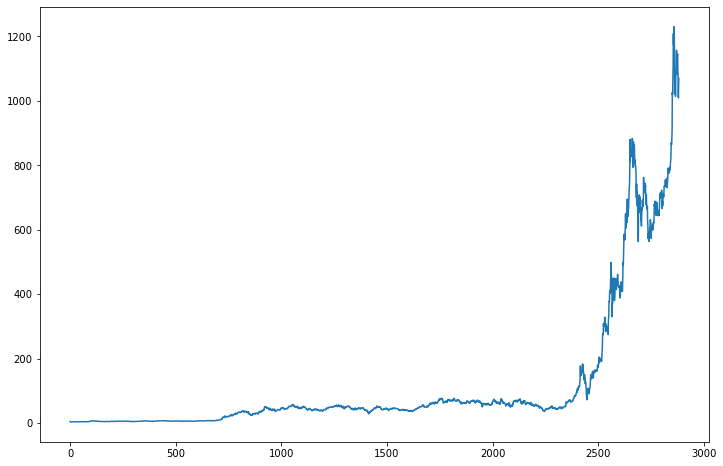

In [12]:
tsla['Close'].plot(figsize=(12,8))

In [13]:
series = tsla['Close']

# Create train data set
train_split_date = '2015-12-31'
train_split_index = np.where(tsla.Date == train_split_date)[0][0]
x_train = tsla.loc[tsla['Date'] <= train_split_date]['Close']

# Create test data set
test_split_date = '2018-01-02'
test_split_index = np.where(tsla.Date == test_split_date)[0][0]
x_test = tsla.loc[tsla['Date'] >= test_split_date]['Close']

# Create valid data set
valid_split_index = (train_split_index.max(),test_split_index.min())
x_valid = tsla.loc[(tsla['Date'] < test_split_date) & (tsla['Date'] > train_split_date)]['Close']

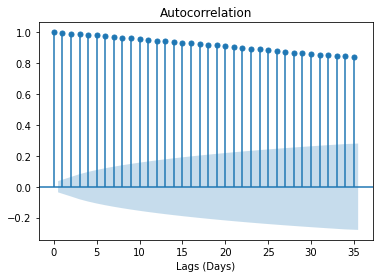

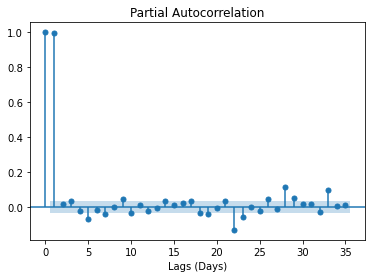

In [14]:
# Plot of autocorrelation

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(series)
plt.xlabel('Lags (Days)')
plt.show()

## Plot of partial autocorrelation

plot_pacf(series)
plt.xlabel('Lags (Days)')
plt.show()

### When plotting the value of the ACF for increasing lags, the values tend to degrade to zero quickly for stationary time series , while for non-stationary data the degradation will happen more slowly hence we can conclude that the time series is not stationary

### We Also Perform Dickey-Fuller test

In [15]:
 #Perform Dickey-Fuller test:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(series, autolag='AIC', maxlag = 20 )
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
pvalue = dftest[1]
if pvalue < 0.05:
    print('p-value = %.4f. The series is likely stationary.' % pvalue)
else:
    print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
print(dfoutput)

Results of Dickey-Fuller Test:
p-value = 1.0000. The series is likely non-stationary.
Test Statistic                    2.992816
p-value                           1.000000
#Lags Used                       20.000000
Number of Observations Used    2862.000000
Critical Value (1%)              -3.432637
Critical Value (5%)              -2.862550
Critical Value (10%)             -2.567308
dtype: float64


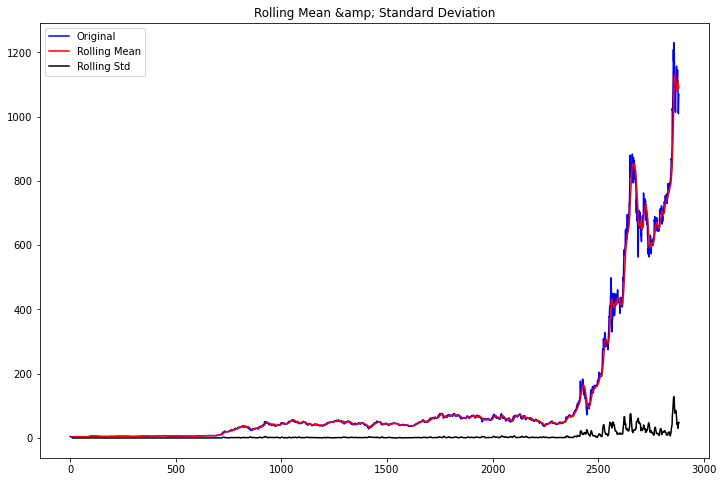

In [16]:
#Determing rolling statistics
rolmean = series.rolling(12).mean()
rolstd = series.rolling(12).std()

#Plot rolling statistics:
fig = plt.figure(figsize=(12, 8))
orig = plt.plot(series, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean &amp; Standard Deviation')
plt.show()

In [17]:
#Convert our non-stationary data to stationary data using the differencing method
new_series= series.diff()
new_series.dropna(inplace=True)
#test_stationarity(new_series)

In [18]:
#Perform Dickey-Fuller test:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(new_series, autolag='AIC', maxlag = 20 )
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
pvalue = dftest[1]
if pvalue < 0.05:
    print('p-value = %.4f. The series is likely stationary.' % pvalue)
else:
    print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
print(dfoutput)

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -1.074817e+01
p-value                        2.707931e-19
#Lags Used                     2.000000e+01
Number of Observations Used    2.861000e+03
Critical Value (1%)           -3.432638e+00
Critical Value (5%)           -2.862551e+00
Critical Value (10%)          -2.567308e+00
dtype: float64


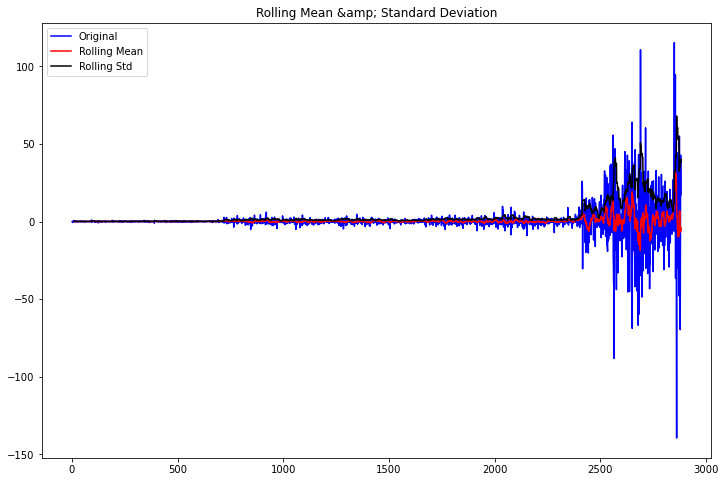

In [19]:
#Determing rolling statistics
rolmean = new_series.rolling(12).mean()
rolstd = new_series.rolling(12).std()

#Plot rolling statistics:
fig = plt.figure(figsize=(12, 8))
orig = plt.plot(new_series, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean &amp; Standard Deviation')
plt.show()

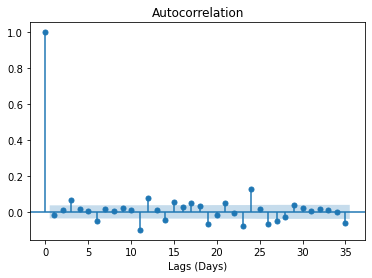

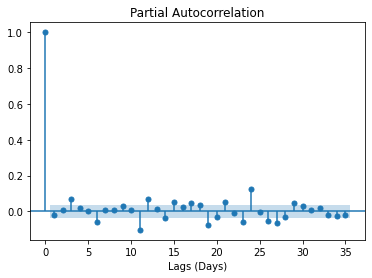

In [20]:
# Plot of autocorrelation

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(new_series)
plt.xlabel('Lags (Days)')
plt.show()

## Plot of partial autocorrelation

plot_pacf(new_series)
plt.xlabel('Lags (Days)')
plt.show()

In [21]:
from statsmodels.tsa.arima_model import ARIMA


### Selecting the best p, d, q parameters for the ARIMA model by using the AIC (Akaike Information Critera )

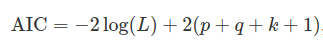

In [22]:
import itertools
p=d=q=range(0,3)
pdq =list(itertools.product(p,d,q))

In [23]:

import warnings
warnings.filterwarnings("ignore")
AIC={}
for i in pdq:
    try:
        tsla_arima=ARIMA(x_train,order=(i))
        model_fit=tsla_arima.fit()
        print('AIC value -> ',model_fit.aic)
        print("(p,d,q) -> ",i)
        print('------------------------\n')
        AIC[model_fit.aic]=i
    except:
        continue

AIC value ->  12079.908181671082
(p,d,q) ->  (0, 0, 0)
------------------------

AIC value ->  10247.266521120002
(p,d,q) ->  (0, 0, 1)
------------------------

AIC value ->  8762.88754844423
(p,d,q) ->  (0, 0, 2)
------------------------

AIC value ->  3483.6817028572705
(p,d,q) ->  (0, 1, 0)
------------------------

AIC value ->  3485.5946628900406
(p,d,q) ->  (0, 1, 1)
------------------------

AIC value ->  3487.005931737149
(p,d,q) ->  (0, 1, 2)
------------------------

AIC value ->  4431.980758096913
(p,d,q) ->  (0, 2, 0)
------------------------

AIC value ->  3491.2512338585216
(p,d,q) ->  (0, 2, 1)
------------------------

AIC value ->  3493.150278292095
(p,d,q) ->  (0, 2, 2)
------------------------

AIC value ->  3495.861026967308
(p,d,q) ->  (1, 0, 0)
------------------------

AIC value ->  3497.728866521523
(p,d,q) ->  (1, 0, 1)
------------------------

AIC value ->  3499.253684325634
(p,d,q) ->  (1, 0, 2)
------------------------

AIC value ->  3485.598105161499
(p,d

#### Finding the best parameter with minimum AIC value

In [24]:
print('Best parameters p, d and q ->',AIC[min(AIC.keys())])


Best parameters p, d and q -> (0, 1, 0)


In [25]:
### Fitting the model
tsla_arima = ARIMA(x_train, order=(0,1,0))
tsla_arima_fit = tsla_arima.fit(disp=0)
print(tsla_arima_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1387
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1739.841
Method:                           css   S.D. of innovations              0.848
Date:                Wed, 08 Dec 2021   AIC                           3483.682
Time:                        20:15:43   BIC                           3494.151
Sample:                             1   HQIC                          3487.597
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0312      0.023      1.368      0.171      -0.013       0.076


In [26]:
# Create list of x train valuess
history = [x for x in x_train]

# establish list for predictions
model_predictions = []

# Count number of test data points
N_test_observations = len(x_test)

# loop through every data point
for time_point in list(x_test.index):
    model = ARIMA(history, order=(0,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = x_test[time_point]
    history.append(true_test_value)
MAE_error = mean_squared_error(x_test, model_predictions)
print('Testing Mean Squared Error is {}'.format(MAE_error))

# %store model_predictions

Testing Mean Squared Error is 247.2989106988531


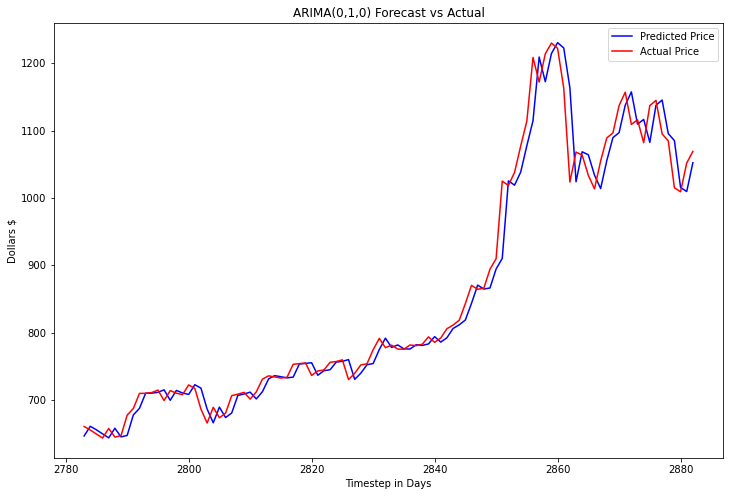

In [27]:
# Plot our predictions against the actual values for a visual comparison.
fig = plt.figure(figsize=(12, 8))
plt.plot(x_test.index[-100:], model_predictions[-100:], color='blue',label='Predicted Price')
plt.plot(x_test.index[-100:], x_test[-100:], color='red', label='Actual Price')
plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.title('ARIMA(0,1,0) Forecast vs Actual')
plt.legend()

plt.savefig('TSLA_ARIMA_Predict.jpeg')
plt.show()


### K - means Clustering

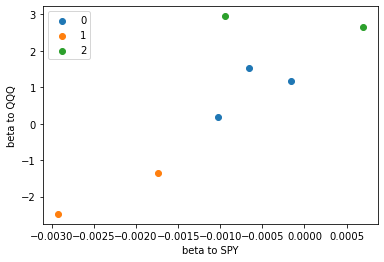

               0
Cluster index   
TSLA           1
GM             2
F              2
HMC            0
TM             0
RACE           0
NIO            1


In [28]:
#Clustering
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as pyplot

# Stock Selection 
LIST = ['TSLA','GM','F','HMC','TM','RACE','NIO']
start_date = datetime(2021,1,1)
end_date = datetime(2021,8,31)
FACTOR = ['SPY', 'QQQ']        
N = len(LIST)
PORTFOLIO = pd.DataFrame(columns = LIST) 
for n in range(0, N):
    PRICE = DataReader(LIST[n], 'yahoo', start_date,end_date)
    RETURN = np.diff(np.log(PRICE['Adj Close'].values))
    PORTFOLIO[LIST[n]] = RETURN
    # First Pass - TIME SERIES
    T = PORTFOLIO.shape[0]
    SPY = DataReader(FACTOR[0], 'yahoo', start_date,end_date)
    F1 = np.diff(np.log(SPY['Adj Close'].values))
    QQQ = DataReader(FACTOR[1], 'yahoo', start_date,end_date)
    F2 = np.diff(np.log(QQQ['Adj Close'].values))
    X = np.asmatrix(np.column_stack([np.ones((T,1)), F1, F2]))
    K = X.shape[1]
beta = np.zeros([K,N])
Y = np.zeros([T,N]) 
for n in range(0, N):
    Y[:,n] = PORTFOLIO[LIST[n]].values
    #Linear Regression of Y: T x 1 on 
    # Regressors X: T x N
    invXX = np.linalg.inv(X.transpose()@X)
    #OLS estimator beta: N x 1'
    beta[:,n] = invXX@X.transpose()@Y[:,n]


X = beta.transpose()
# K Mean Clustering
from sklearn.cluster import KMeans
# define the model
model = KMeans(n_clusters=3)
# fit the model
model.fit(X)
# assign a cluster to each example
yhat = model.predict(X)
# retrieve unique clusters
clusters = np.unique(yhat)
# create scatter plot for samples from each cluster
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = np.where(yhat == cluster)
	# create scatter of these samples


	plt.scatter(X[row_ix, 0], X[row_ix, 1],label=cluster)

# show the plot
pyplot.xlabel("beta to SPY")
pyplot.ylabel("beta to QQQ")
pyplot.legend()
pyplot.show()


df2 = pd.DataFrame(yhat,LIST)
index = df2.index
index.name = "Cluster index"
print(df2)

### Agglomerative Clustering

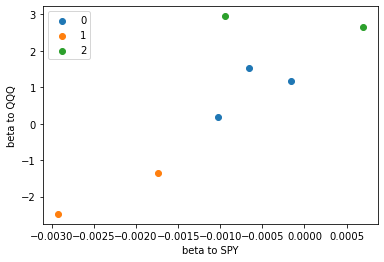

               0
Cluster index   
TSLA           1
GM             2
F              2
HMC            0
TM             0
RACE           0
NIO            1


In [29]:

# define the model
model = AgglomerativeClustering(n_clusters=3)
# fit model and predict clusters
yhat = model.fit_predict(X)
# retrieve unique clusters
clusters = unique(yhat)
# create scatter plot for samples from each cluster
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = where(yhat == cluster)
	# create scatter of these samples
	pyplot.scatter(X[row_ix, 0], X[row_ix, 1],label=cluster)
# show the plot
pyplot.xlabel("beta to SPY")
pyplot.ylabel("beta to QQQ")
pyplot.legend()
pyplot.show()        
# print(yhat)

df1 = pd.DataFrame(yhat,LIST)
index = df1.index
index.name = "Cluster index"
print(df1)



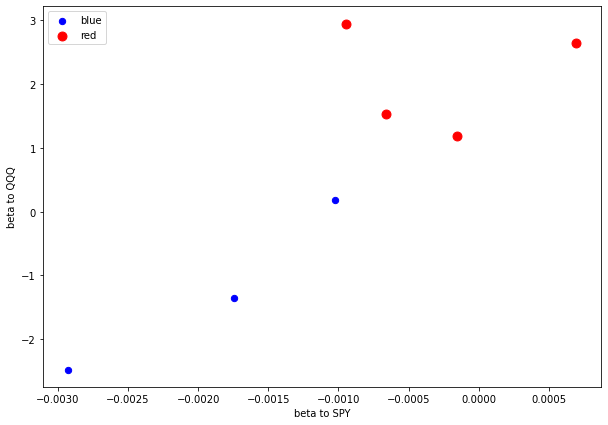

In [30]:
#Isolation Forest


# Stock Selection 
LIST = ['TSLA','GM','F','HMC','TM','RACE','NIO']
start_date = datetime(2021,1,1)
end_date = datetime(2021,8,31)
FACTOR = ['SPY', 'QQQ']        
N = len(LIST)
PORTFOLIO = pd.DataFrame(columns = LIST) 
for n in range(0, N):
    PRICE = DataReader(LIST[n], 'yahoo', start_date,end_date)
    RETURN = np.diff(np.log(PRICE['Adj Close'].values))
    PORTFOLIO[LIST[n]] = RETURN
 
 # First Pass - TIME SERIES
    T = PORTFOLIO.shape[0]
    SPY = DataReader(FACTOR[0], 'yahoo', start_date,end_date)
    F1 = np.diff(np.log(SPY['Adj Close'].values))
    QQQ = DataReader(FACTOR[1], 'yahoo', start_date,end_date)
    F2 = np.diff(np.log(QQQ['Adj Close'].values))
    X = np.asmatrix(np.column_stack([np.ones((T,1)), F1, F2]))
    K = X.shape[1]
    
beta = np.zeros([K,N])
Y = np.zeros([T,N]) 
for n in range(0, N):
    Y[:,n] = PORTFOLIO[LIST[n]].values
    #Linear Regression of Y: T x 1 on 
    # Regressors X: T x N
    invXX = np.linalg.inv(X.transpose()@X)
    #OLS estimator beta: N x 1'
    beta[:,n] = invXX@X.transpose()@Y[:,n]


fig = plt.figure(figsize = (10, 7))    
plt.scatter(beta[0,:], beta[1,:], color = 'b', s = 40,label='blue')
plt.xlabel('beta to SPY')
plt.ylabel('beta to QQQ')
plt.scatter(beta[0,:][beta[1,:]>1], beta[1,:][beta[1,:]>1], color = 'r', s= 80,label='red')
plt.legend()
plt.show()

model=IsolationForest(n_estimators=1000, max_samples='auto', contamination=float(.12), \
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)

model.fit(beta.transpose())
scores = model.decision_function(beta.transpose())
pred = model.predict(beta.transpose())

In [31]:
df3 = pd.DataFrame(LIST,pred)
df3

,0
1,TSLA
1,GM
1,F
1,HMC
1,TM
1,RACE
-1,NIO



## LSTM Model

In [32]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import yfinance as yf
import math
keras = tf.keras
from sklearn.metrics import mean_squared_error

In [33]:
tsla = yf.Ticker("TSLA")

# To get stock info
tsla.info

# get historical market data as df
hist = yf.download("TSLA", start="2020-01-01", end="2021-10-28", interval="1d")

# Save dataframe as CSV file
hist.to_csv('TSLA.CSV')

# Read data in to dataframes
tsla = pd.read_csv('TSLA.CSV')

# Change date column to datetime type
tsla['Date'] = pd.to_datetime(tsla['Date'])

tsla.dropna(inplace=True)

train_dates = pd.to_datetime(tsla['Date'])
print(train_dates.tail(10)) #Check last few dates. 

[*********************100%***********************]  1 of 1 completed
450   2021-10-14
451   2021-10-15
452   2021-10-18
453   2021-10-19
454   2021-10-20
455   2021-10-21
456   2021-10-22
457   2021-10-25
458   2021-10-26
459   2021-10-27
Name: Date, dtype: datetime64[ns]


In [34]:
cols = list(tsla)[1:6]
#print(cols)

df_for_training = tsla[cols].astype(float)

### LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized

In [35]:
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

### Reformat input data into a shape: (n_samples x timesteps x n_features)

In [36]:
trainX = []
trainY = []

n_future = 1  # Number of days we want to look into the future based on the past days.
n_past = 15  # Number of past days we want to use to predict the future.


for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])
    
    
    
trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (445, 15, 5).
trainY shape == (445, 1).


### define the autoencoder model

In [37]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 15, 64)            17920     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 30,369
Trainable params: 30,369
Non-trainable params: 0
_________________________________________________________________


### fit the model

Epoch 1/100
25/25 [==============================] - 3s 50ms/step - loss: 0.7265 - val_loss: 0.0202
Epoch 2/100
25/25 [==============================] - 0s 19ms/step - loss: 0.0830 - val_loss: 0.0220
Epoch 3/100
25/25 [==============================] - 0s 17ms/step - loss: 0.0606 - val_loss: 0.0972
Epoch 4/100
25/25 [==============================] - 0s 17ms/step - loss: 0.0533 - val_loss: 0.0245
Epoch 5/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0563 - val_loss: 0.0583
Epoch 6/100
25/25 [==============================] - 0s 19ms/step - loss: 0.0418 - val_loss: 0.0596
Epoch 7/100
25/25 [==============================] - 1s 22ms/step - loss: 0.0536 - val_loss: 0.0119
Epoch 8/100
25/25 [==============================] - 0s 19ms/step - loss: 0.0403 - val_loss: 0.0206
Epoch 9/100
25/25 [==============================] - 0s 18ms/step - loss: 0.0359 - val_loss: 0.0236
Epoch 10/100
25/25 [==============================] - 0s 18ms/step - loss: 0.0383 - val_loss: 0.0401

25/25 [==============================] - 0s 12ms/step - loss: 0.0257 - val_loss: 0.0145
Epoch 83/100
25/25 [==============================] - 0s 12ms/step - loss: 0.0288 - val_loss: 0.0102
Epoch 84/100
25/25 [==============================] - 0s 12ms/step - loss: 0.0218 - val_loss: 0.0034
Epoch 85/100
25/25 [==============================] - 0s 12ms/step - loss: 0.0233 - val_loss: 0.0012
Epoch 86/100
25/25 [==============================] - 0s 12ms/step - loss: 0.0253 - val_loss: 0.0017
Epoch 87/100
25/25 [==============================] - 0s 12ms/step - loss: 0.0286 - val_loss: 0.0035
Epoch 88/100
25/25 [==============================] - 0s 12ms/step - loss: 0.0225 - val_loss: 0.0014
Epoch 89/100
25/25 [==============================] - 0s 12ms/step - loss: 0.0247 - val_loss: 0.0029
Epoch 90/100
25/25 [==============================] - 0s 13ms/step - loss: 0.0264 - val_loss: 0.0027
Epoch 91/100
25/25 [==============================] - 0s 12ms/step - loss: 0.0265 - val_loss: 0.0018
Epo

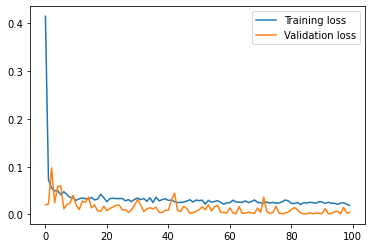

In [38]:
history = model.fit(trainX, trainY, epochs=100, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [39]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
n_past = 15
n_days_for_prediction=15 #predict past 15 days

predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()
print(predict_period_dates)

[Timestamp('2021-10-07 00:00:00', freq='C'), Timestamp('2021-10-08 00:00:00', freq='C'), Timestamp('2021-10-12 00:00:00', freq='C'), Timestamp('2021-10-13 00:00:00', freq='C'), Timestamp('2021-10-14 00:00:00', freq='C'), Timestamp('2021-10-15 00:00:00', freq='C'), Timestamp('2021-10-18 00:00:00', freq='C'), Timestamp('2021-10-19 00:00:00', freq='C'), Timestamp('2021-10-20 00:00:00', freq='C'), Timestamp('2021-10-21 00:00:00', freq='C'), Timestamp('2021-10-22 00:00:00', freq='C'), Timestamp('2021-10-25 00:00:00', freq='C'), Timestamp('2021-10-26 00:00:00', freq='C'), Timestamp('2021-10-27 00:00:00', freq='C'), Timestamp('2021-10-28 00:00:00', freq='C')]


In [40]:
#Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

#Perform inverse transformation to rescale back to original range
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

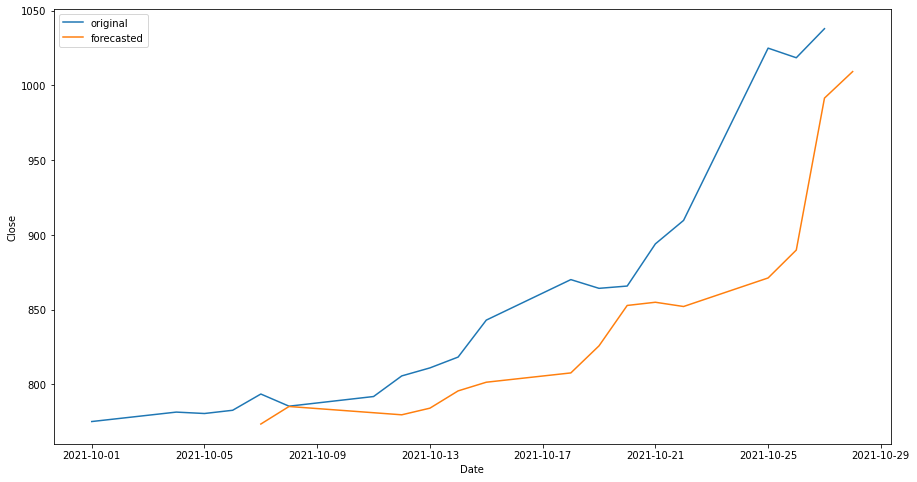

In [41]:
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Close':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])
#df_forecast = df_forecast.loc[df_forecast['Date'] >= '2021-10-27']

original = tsla[['Date', 'Close']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2021-10-1']
plt.figure(figsize = (15,8))

sns.lineplot(original['Date'], original['Close'])
sns.lineplot(df_forecast['Date'], df_forecast['Close'])
plt.legend(labels=["original","forecasted"])

In [42]:
result = pd.merge(original, df_forecast, left_on='Date', right_on='Date')
result.rename(columns={'Close_x': 'original', 'Close_y': 'forecast'}, inplace=True)
display(result)

,Date,original,forecast
0,2021-10-07,793.609985,773.552490
1,2021-10-08,785.489990,785.275818
2,2021-10-12,805.719971,779.722229
3,2021-10-13,811.080017,784.161804
4,2021-10-14,818.320007,795.707825
5,2021-10-15,843.030029,801.505981
6,2021-10-18,870.109985,807.724365
7,2021-10-19,864.270020,825.829712
8,2021-10-20,865.799988,852.828796
9,2021-10-21,894.000000,854.967773


In [43]:
original.tail(10)

,Date,Close
450,2021-10-14,818.320007
451,2021-10-15,843.030029
452,2021-10-18,870.109985
453,2021-10-19,864.270020
454,2021-10-20,865.799988
455,2021-10-21,894.000000
456,2021-10-22,909.679993
457,2021-10-25,1024.859985
458,2021-10-26,1018.429993
459,2021-10-27,1037.859985


In [44]:
df_forecast.tail(10)

,Date,Close
5,2021-10-15,801.505981
6,2021-10-18,807.724365
7,2021-10-19,825.829712
8,2021-10-20,852.828796
9,2021-10-21,854.967773
10,2021-10-22,852.123047
11,2021-10-25,871.215942
12,2021-10-26,889.870667
13,2021-10-27,991.443359
14,2021-10-28,1009.187988


<h2 align='center'>Trading Signal </h2>

In [45]:
start_date = datetime(2020,8,1)
end_date = datetime(2021,8,30)
df_TSLA = yf.download('TSLA',start_date ,end_date)



[*********************100%***********************]  1 of 1 completed


In [46]:
"""Trading Signals using Moving Average"""



df_TSLA['rolling_20'] = df_TSLA['Adj Close'].rolling(20).mean()
df_TSLA['rolling_5'] = df_TSLA['Adj Close'].rolling(5).mean()
datetime_index = df_TSLA.index

def signal_analysis(row):
    if row['rolling_5'] > row['rolling_20']:
        return 1.0
    else:
        return 0.0

df_TSLA['Signal'] = df_TSLA.apply(signal_analysis,axis=1)
df_TSLA['Position'] = df_TSLA['Signal'].diff()

"""Setting x and y axis"""

major_ticks_top = np.arange(50,1100,100)
major_ticks_bottom = pd.date_range('2020-07-30', '2021-08-31', freq = 'W').strftime('%Y-%m-%d')



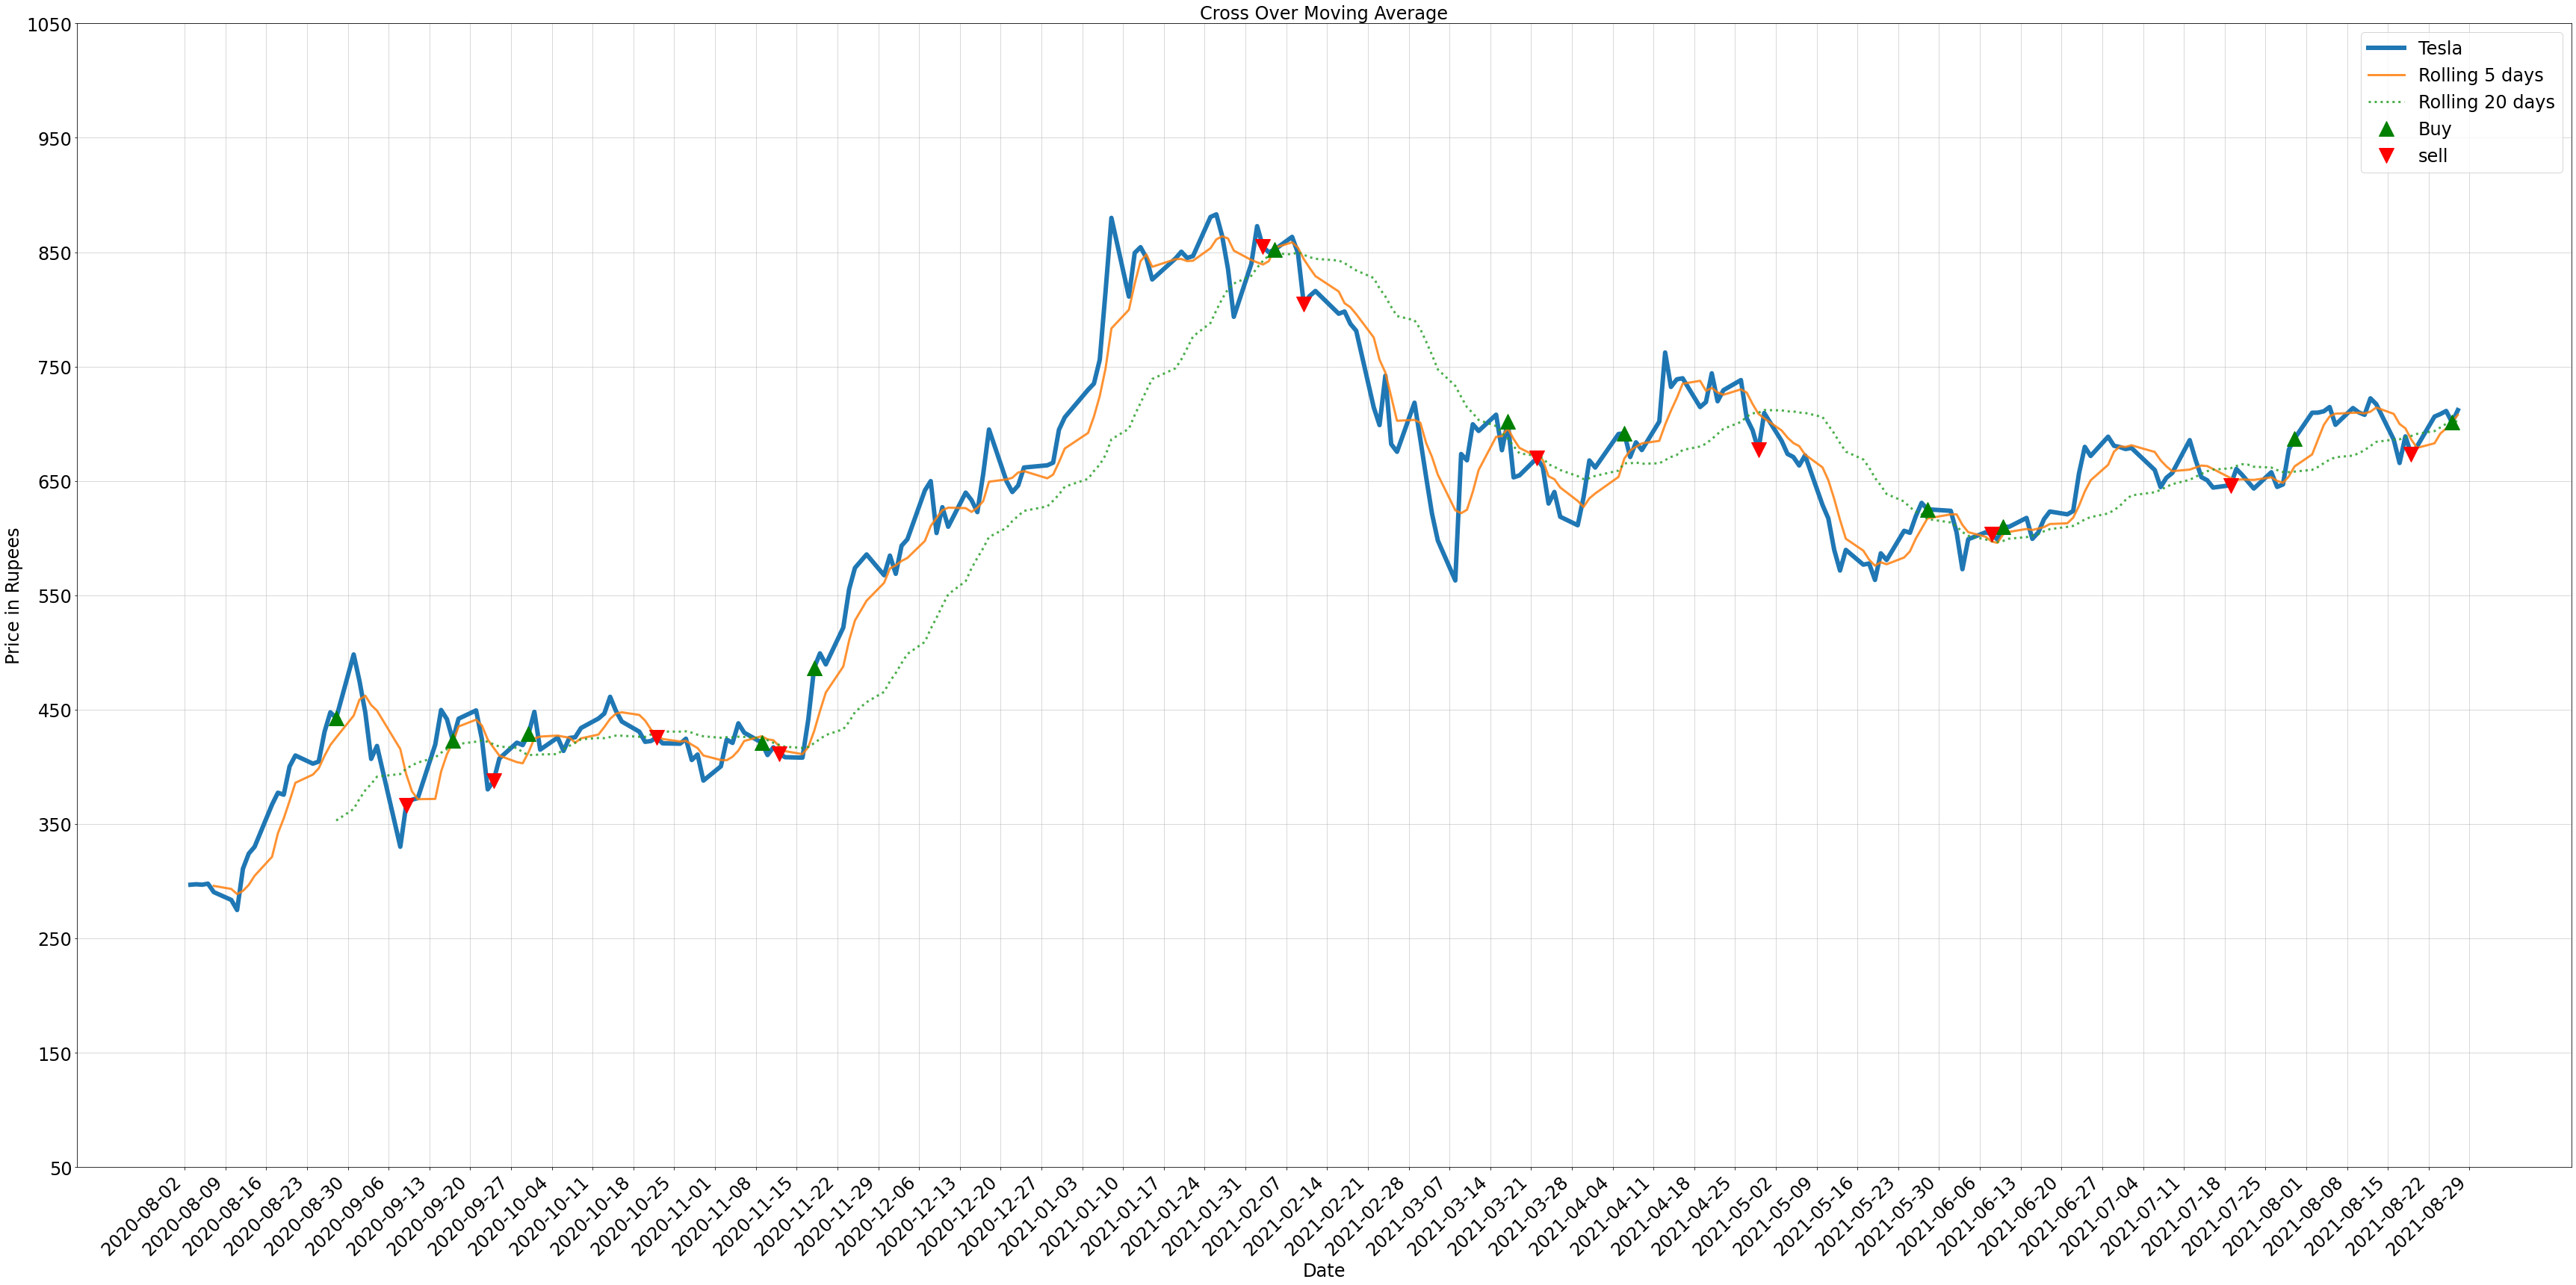

In [47]:


"""Plotting Buy Sell Trade Signals"""

fig, ax = plt.subplots(figsize = (48,24))# plot close price, short-term and long-term moving averages
ax.plot(datetime_index,df_TSLA['Adj Close'],label='Tesla',linewidth=6.0)
ax.plot(datetime_index,df_TSLA['rolling_5'],'-',label='Rolling 5 days',alpha = 0.85,linewidth=3.0)
ax.plot(datetime_index,df_TSLA['rolling_20'], ':',label = 'Rolling 20 days',alpha = 0.85,linewidth=3.0)

""" Plot Buy signals"""

ax.plot(df_TSLA[df_TSLA['Position'] == 1].index,
         df_TSLA['Adj Close'][df_TSLA['Position'] == 1],
         '^', markersize = 20, color = 'g', label = 'Buy')

""" Plot Sell signals"""

ax.plot(df_TSLA[df_TSLA['Position'] == -1].index,
         df_TSLA['Adj Close'][df_TSLA['Position'] == -1],
         'v', markersize = 20, color = 'r', label = 'sell')

"""Details"""

ax.set_ylabel('Price in Rupees', fontsize = 24 )
ax.set_xlabel('Date', fontsize = 24 )
ax.set_yticks(major_ticks_top)
ax.set_xticks(major_ticks_bottom)
ax.set_xticklabels(major_ticks_bottom,rotation = 45,ha = 'right')
ax.tick_params(axis = 'x', labelsize = 24)
ax.tick_params(axis = 'y', labelsize = 24)
ax.set_title('Cross Over Moving Average', fontsize = 24)
ax.legend(fontsize=24)
ax.grid(which = "major",alpha = 0.6)
ax.grid(which = "minor",alpha = 0.3)
fig.tight_layout()
#fig.savefig('Cross Over Moving Average.png')

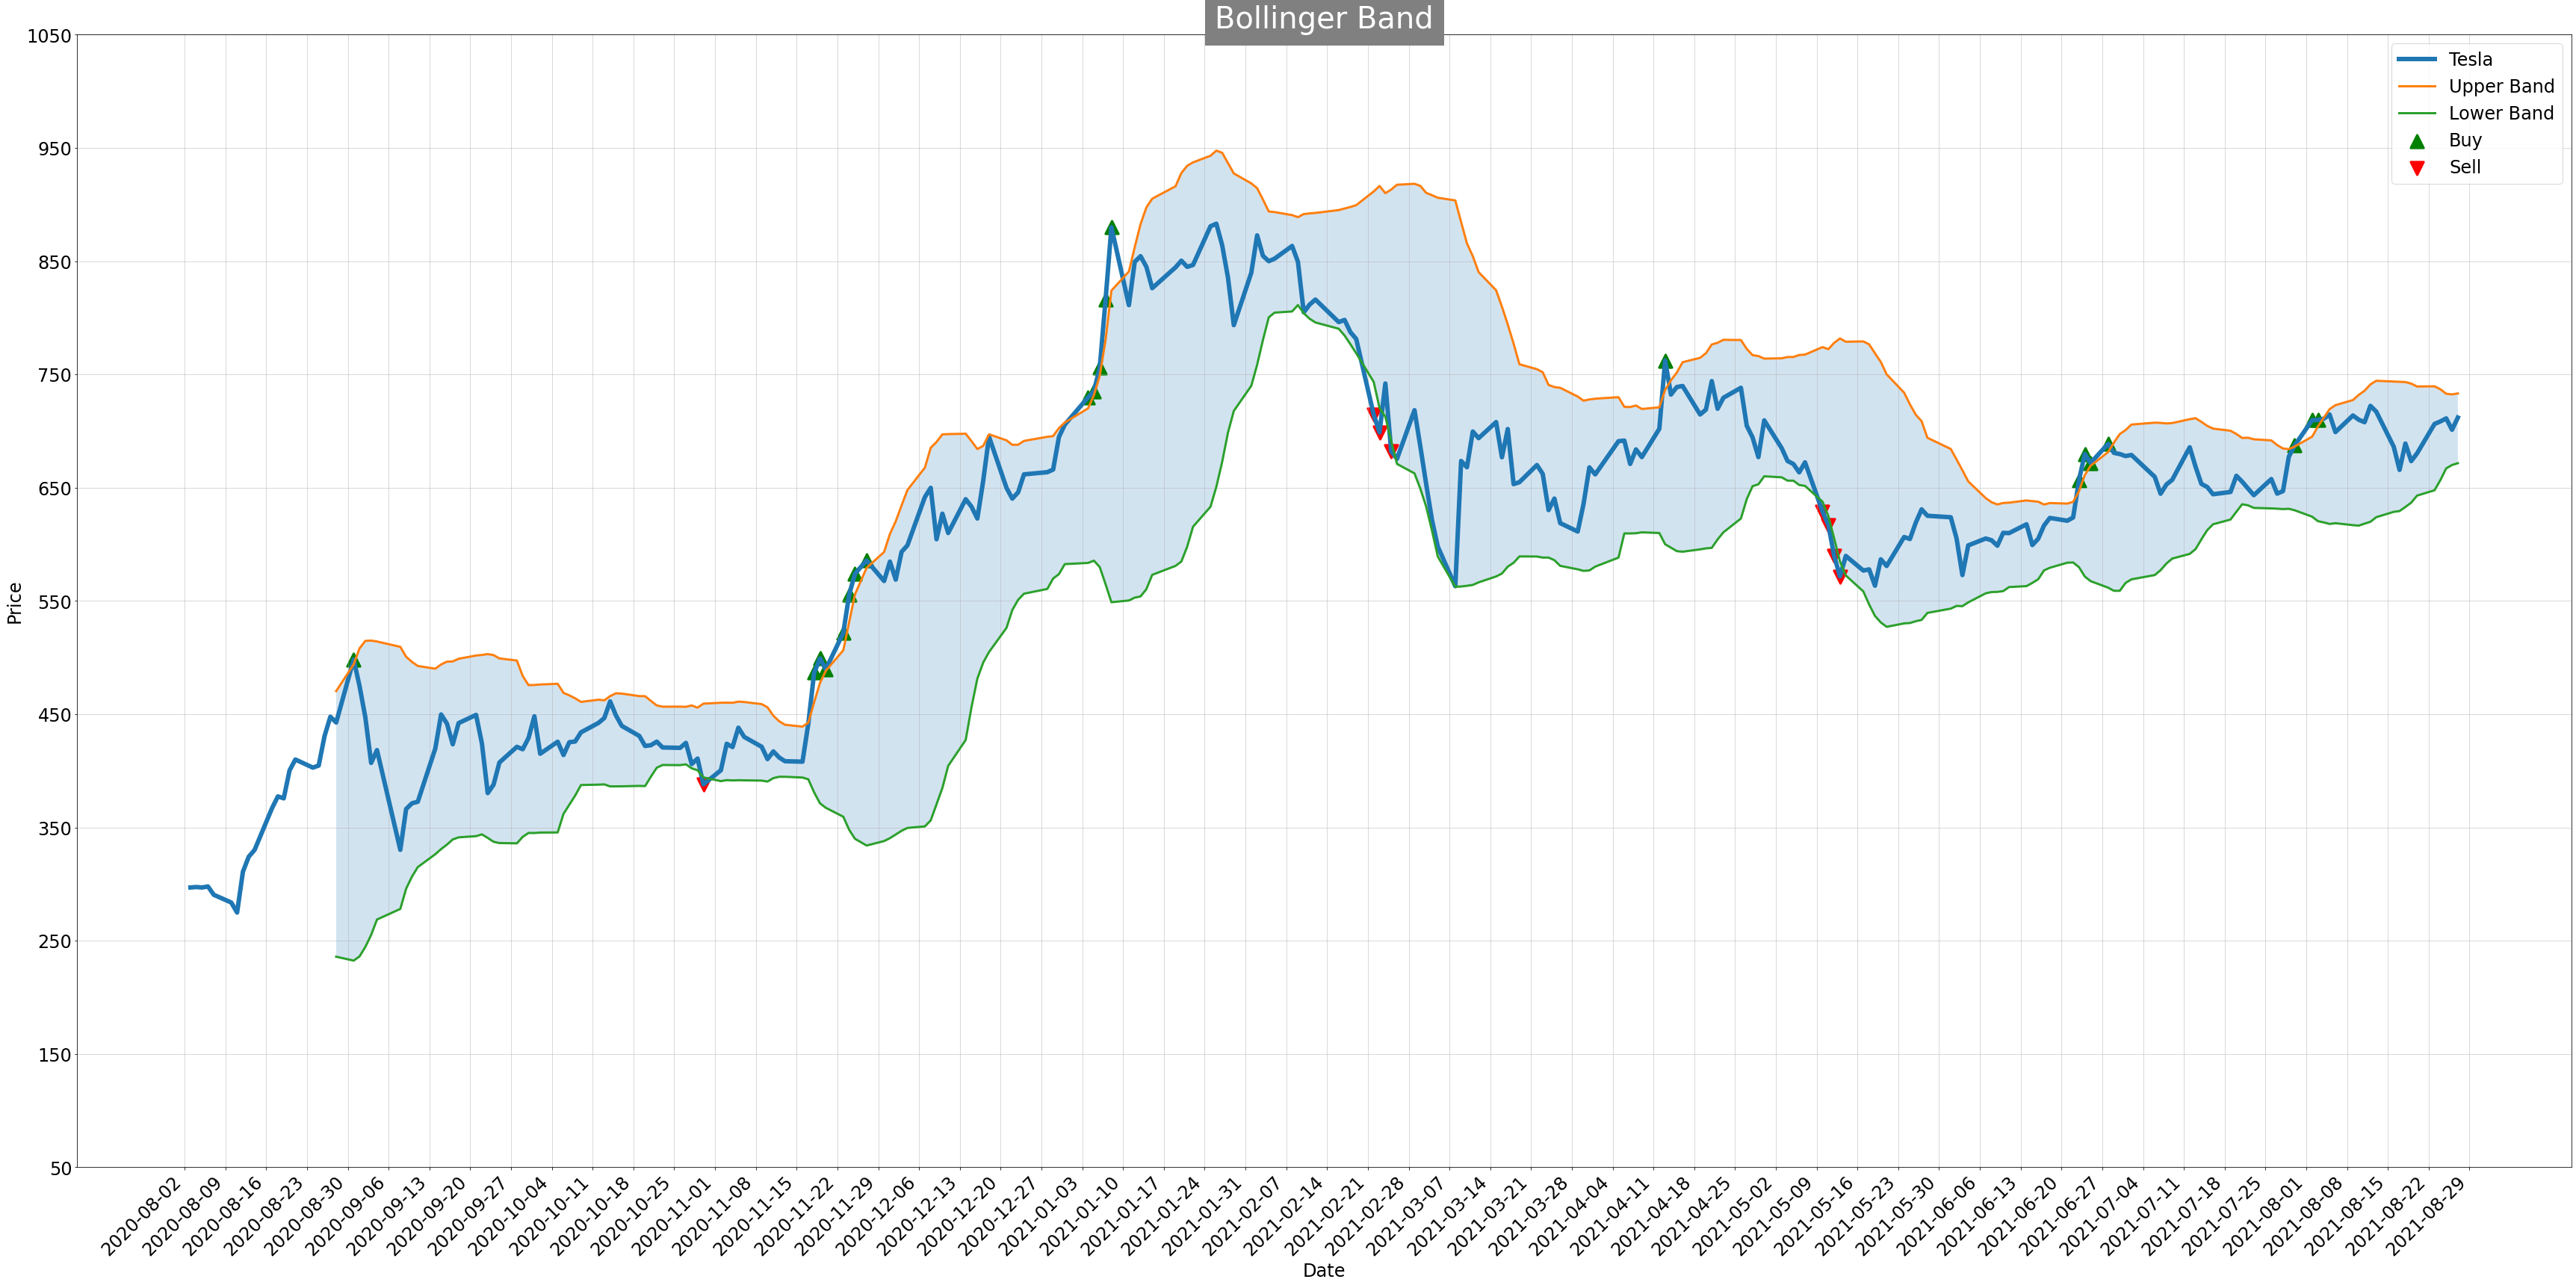

In [48]:




"""Bollinger Band"""

df_TSLA['Upper Band'] = df_TSLA['Adj Close'].rolling(20).mean() + (2 * df_TSLA['Adj Close'].rolling(20).std())
df_TSLA['Lower Band'] = df_TSLA['Adj Close'].rolling(20).mean() - (2 * df_TSLA['Adj Close'].rolling(20).std())



"""Calculating Buy and Sell"""

def bollinger_sell(row):
    if row['Adj Close'] < row['Lower Band']:
        return row['Adj Close']
    elif row['Adj Close'] > row['Upper Band']:
        return np.nan
    else:
        return np.nan


def bollinger_buy(row):
    if row['Adj Close'] < row['Lower Band']:
        return np.nan
    elif row['Adj Close'] > row['Upper Band']:
        return row['Adj Close']
    else:
        return np.nan


df_TSLA['Bollinger Buy'] = df_TSLA.apply(bollinger_buy,axis=1)
df_TSLA['Bollinger Sell'] = df_TSLA.apply(bollinger_sell,axis=1)

"""Plotting Trading Signal"""




try:
    fig, ax = plt.subplots(figsize = (48,24))#
    ax.plot(datetime_index,df_TSLA['Adj Close'],label='Tesla',linewidth=6.0)
    ax.plot(datetime_index,df_TSLA['Upper Band'],label = 'Upper Band',linewidth=3.0)
    ax.plot(datetime_index,df_TSLA['Lower Band'],label = 'Lower Band',linewidth=3.0)
    ax.fill_between(datetime_index, df_TSLA['Lower Band'], df_TSLA['Upper Band'], alpha=0.2)

    """ Plot Buy signals"""

    ax.scatter(datetime_index , df_TSLA['Bollinger Buy'] , label = 'Buy' ,
    marker = '^', color = 'green',alpha =1,s = 300,linewidth = 3.0 )

    """ Plot Sell signals"""

    ax.scatter(datetime_index , df_TSLA['Bollinger Sell']  , label = 'Sell',
    marker = 'v', color = 'red',alpha =1,s = 300,linewidth = 3.0)

    """Details"""

    ax.set_xlabel('Date',fontsize=24)
    ax.set_ylabel('Price',fontsize=24)
    ax.set_yticks(major_ticks_top)
    ax.set_xticks(major_ticks_bottom)
    ax.set_title('Bollinger Band',backgroundcolor='grey',color='white',fontsize=30)
    ax.tick_params(axis = 'x', labelsize = 24)
    ax.tick_params(axis = 'y', labelsize = 24)
    ax.set_xticklabels(major_ticks_bottom,rotation = 45,ha = 'right')
    ax.grid(which = "major",alpha = 0.6)
    ax.grid(which = "minor",alpha = 0.3)
    ax.legend(fontsize = 24)
    ax.set_title('Bollinger Band',fontsize=40,backgroundcolor = 'grey',color='white')
    fig.tight_layout()
    fig.savefig('BollingerBand.png')

except Exception as e:
    print(e)

### Random Forest

In [63]:
# Import libraries
import os
import sys
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import accuracy_score, classification_report


In [64]:
days_out = 30

# create a new column that will house the flag,  
# and for each group calculate the diff. Then use Numpy to define the sign.
tsla['Signal_Flag'] = tsla['Close'].transform(lambda x : np.sign(x.diff(days_out)))

# print the first 10 rows
tsla.head(10)

In [74]:
tsla.sort_values(by = ['Date'], inplace = True)

# calculate the change in price
tsla['change_in_price'] = tsla['Close'].diff()

#tsla[tsla.isna().any(axis = 1)]

In [67]:
# Calculate the 14 day RSI
n = 14

# First make a copy of the data frame twice
up_df, down_df = tsla[['change_in_price']].copy(), tsla[['change_in_price']].copy()

# For up days, if the change is less than 0 set to 0.
up_df.loc['change_in_price'] = up_df.loc[(up_df['change_in_price'] < 0), 'change_in_price'] = 0

# For down days, if the change is greater than 0 set to 0.
down_df.loc['change_in_price'] = down_df.loc[(down_df['change_in_price'] > 0), 'change_in_price'] = 0

# We need change in price to be absolute.
down_df['change_in_price'] = down_df['change_in_price'].abs()

# Calculate the EWMA (Exponential Weighted Moving Average), meaning older values are given less weight compared to newer values.
ewma_up = up_df['change_in_price'].transform(lambda x: x.ewm(span = n).mean())
ewma_down = down_df['change_in_price'].transform(lambda x: x.ewm(span = n).mean())

# Calculate the Relative Strength
relative_strength = ewma_up / ewma_down

# Calculate the Relative Strength Index
relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))

# Add the info to the data frame.
tsla['down_days'] = down_df['change_in_price']
tsla['up_days'] = up_df['change_in_price']
tsla['RSI'] = relative_strength_index

# Display the head.
tsla.head(10)

In [68]:

# Calculate the Stochastic Oscillator
n = 14

# Make a copy of the high and low column.
low_14, high_14 = tsla[['Low']].copy(), tsla[['High']].copy()

# Group by symbol, then apply the rolling function and grab the Min and Max.
low_14 = low_14['Low'].transform(lambda x: x.rolling(window = n).min())
high_14 = high_14['High'].transform(lambda x: x.rolling(window = n).max())

# Calculate the Stochastic Oscillator.
k_percent = 100 * ((tsla['Close'] - low_14) / (high_14 - low_14))

# Add the info to the data frame.
tsla['low_14'] = low_14
tsla['high_14'] = high_14
tsla['k_percent'] = k_percent

# Display the head.
tsla.head(10)

In [69]:
# Calculate the Williams %R
n = 14

# Make a copy of the high and low column.
low_14, high_14 = tsla[['Low']].copy(), tsla[['High']].copy()

# Group by symbol, then apply the rolling function and grab the Min and Max.
low_14 = low_14['Low'].transform(lambda x: x.rolling(window = n).min())
high_14 = high_14['High'].transform(lambda x: x.rolling(window = n).max())

# Calculate William %R indicator.
r_percent = ((high_14 - tsla['Close']) / (high_14 - low_14)) * - 100

# Add the info to the data frame.
tsla['r_percent'] = r_percent

# Display the head.
tsla.head(10)


In [71]:
# Calculate the MACD
ema_26 = tsla['Close'].transform(lambda x: x.ewm(span = 26).mean())
ema_12 = tsla['Close'].transform(lambda x: x.ewm(span = 12).mean())
macd = ema_12 - ema_26

# Calculate the EMA
ema_9_macd = macd.ewm(span = 9).mean()

# Store the data in the data frame.
tsla['MACD'] = macd
tsla['MACD_EMA'] = ema_9_macd

# Print the head.
tsla.head(10)


In [72]:
# Calculate the Price Rate of Change
n = 9

# Calculate the Rate of Change in the Price, and store it in the Data Frame.
tsla['Price_Rate_Of_Change'] = tsla['Close'].transform(lambda x: x.pct_change(periods = n))

# Print the first 5 rows
tsla.head(5)


In [57]:
def obv(group):

    # Grab the volume and close column.
    volume = tsla['Volume']
    change = tsla['Close'].diff()

    # intialize the previous OBV
    prev_obv = 0
    obv_values = []

    # calculate the On Balance Volume
    for i, j in zip(change, volume):

        if i > 0:
            current_obv = prev_obv + j
        elif i < 0:
            current_obv = prev_obv - j
        else:
            current_obv = prev_obv

        # OBV.append(current_OBV)
        prev_obv = current_obv
        obv_values.append(current_obv)
    
    # Return a panda series.
    return pd.Series(obv_values, index = group.index)
        

# apply the function to each group
obv_groups = tsla.apply(obv)

# add to the data frame, but drop the old index, before adding it.
#tsla['On Balance Volume'] = obv_groups.reset_index(level=0, drop=True)

# display the data frame.
tsla.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume,Signal_Flag,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change
0,2020-01-02,84.900002,86.139999,84.342003,86.052002,86.052002,47660500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN
1,2020-01-03,88.099998,90.800003,87.384003,88.601997,88.601997,88892500,NaN,2.549995,0.0,2.549995,100.0,NaN,NaN,NaN,NaN,0.057211,0.031784,NaN
2,2020-01-06,88.094002,90.311996,88.000000,90.307999,90.307999,50665000,NaN,1.706001,0.0,1.706001,100.0,NaN,NaN,NaN,NaN,0.125802,0.070316,NaN
3,2020-01-07,92.279999,94.325996,90.671997,93.811996,93.811996,89410500,NaN,3.503998,0.0,3.503998,100.0,NaN,NaN,NaN,NaN,0.280425,0.141491,NaN
4,2020-01-08,94.739998,99.697998,93.646004,98.428001,98.428001,155721500,NaN,4.616005,0.0,4.616005,100.0,NaN,NaN,NaN,NaN,0.542223,0.260700,NaN


In [58]:
# Create a prediction column
'''
    Creating an output column that will be 1 if the closing price at time 't' is greater than 't-1' and 0 otherwise.
    That is, if the today's closing price is greater than yesterday's closing price it would be 1.
'''

# Grab the `Close` column.
close_groups = tsla['Close']

# Apply the lambda function which will return -1.0 for down, 1.0 for up and 0.0 for no change.
close_groups = close_groups.transform(lambda x : np.sign(x.diff()))

# add the data to the main dataframe.
tsla['Prediction'] = close_groups

# To keep the prediction column as a binary classifier will change flat days and consider them up days.
tsla.loc[tsla['Prediction'] == 0.0] = 1.0

# print the head
tsla.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume,Signal_Flag,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,Prediction
0,2020-01-02 00:00:00,84.900002,86.139999,84.342003,86.052002,86.052002,47660500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN
1,2020-01-03 00:00:00,88.099998,90.800003,87.384003,88.601997,88.601997,88892500,NaN,2.549995,0.0,2.549995,100.0,NaN,NaN,NaN,NaN,0.057211,0.031784,NaN,1.0
2,2020-01-06 00:00:00,88.094002,90.311996,88.000000,90.307999,90.307999,50665000,NaN,1.706001,0.0,1.706001,100.0,NaN,NaN,NaN,NaN,0.125802,0.070316,NaN,1.0
3,2020-01-07 00:00:00,92.279999,94.325996,90.671997,93.811996,93.811996,89410500,NaN,3.503998,0.0,3.503998,100.0,NaN,NaN,NaN,NaN,0.280425,0.141491,NaN,1.0
4,2020-01-08 00:00:00,94.739998,99.697998,93.646004,98.428001,98.428001,155721500,NaN,4.616005,0.0,4.616005,100.0,NaN,NaN,NaN,NaN,0.542223,0.260700,NaN,1.0


In [59]:
# We need to remove all rows that have an NaN value.
print('Before NaN Drop we have {} rows and {} columns'.format(tsla.shape[0], tsla.shape[1]))

# Any row that has a `NaN` value will be dropped.
tsla = tsla.dropna()

# Display the remaining data after deleting NaN
print('After NaN Drop we have {} rows and {} columns'.format(tsla.shape[0], tsla.shape[1]))

# Print the head.
tsla.head()


Before NaN Drop we have 460 rows and 20 columns
After NaN Drop we have 430 rows and 20 columns


,Date,Open,High,Low,Close,Adj Close,Volume,Signal_Flag,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,Prediction
30,2020-02-14 00:00:00,157.444000,162.593994,157.100006,160.005997,160.005997,78468500,1.0,-0.794006,0.794006,0.000000,68.393742,111.615997,193.798004,58.881501,-41.118499,11.273186,10.062782,0.025679,-1.0
31,2020-02-18 00:00:00,168.320007,172.000000,166.472000,171.679993,171.679993,81908500,1.0,11.673996,0.000000,11.673996,75.819591,113.486000,193.798004,72.459893,-27.540107,12.033802,10.457298,-0.032309,1.0
32,2020-02-19 00:00:00,184.699997,188.955994,180.203995,183.483994,183.483994,127115000,1.0,11.804001,0.000000,11.804001,81.021779,123.599998,193.798004,85.307260,-14.692740,13.363394,11.038886,0.248700,1.0
33,2020-02-20 00:00:00,182.389999,182.399994,171.988007,179.882004,179.882004,88174500,1.0,-3.601990,3.601990,0.000000,75.316539,126.503998,193.798004,79.320595,-20.679405,13.980533,11.627514,0.200879,-1.0
34,2020-02-21 00:00:00,181.395996,182.612000,176.089996,180.199997,180.199997,71574000,1.0,0.317993,0.000000,0.317993,75.492330,134.703995,193.798004,76.989195,-23.010805,14.325835,12.167397,0.204433,1.0


In [60]:
# Splitting data into x and y columns
X_Cols = tsla[['RSI','k_percent','r_percent','Price_Rate_Of_Change','MACD']]
Y_Cols = tsla['Prediction']

# Splitting it further into train and test values
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Creating a Random Forest Classifier
rand_frst_clf = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)

# Fit the data to the model
rand_frst_clf.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf.predict(X_test)

### Finding the Accuracy

In [61]:
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  61.111111111111114


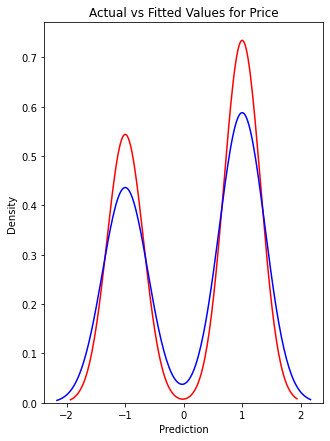

In [62]:
plt.figure(figsize=(5, 7))


ax = sns.distplot(y_train, hist=False, color="r", label="Actual Value")
sns.distplot(y_pred, hist=False, color="b", label="Fitted Values" , ax=ax)


plt.title('Actual vs Fitted Values for Price')


plt.show()
plt.close()